# NMR spectrum analysis

## 1. Получение спектра 

### 1.1 Загрузка даных

In [1]:
import numpy as np
import nmrglue as nmr

Содержимое папки `1H`:

In [2]:
ls 1H

1H-0-CDCl3.fid/  1H-2-CDCl3.fid/  1H-4-CDCl3.fid/  Брутоформулы.txt
1H-1-CDCl3.fid/  1H-3-CDCl3.fid/  1H-5-CDCl3.fid/


Брутто-формулы (как видно наша это `C6H12O2` под номером 2):

In [3]:
cat 1H/Брутоформулы.txt

0	C4H8O2
1	C3H6O2
2	C6H12O2
3	C8H8O3
4	C5H10O2
5	C4H10O2


In [4]:
# nmrglue.variant.read() принимает папку, а не файл
metadata, signal = nmr.varian.read("1H/1H-2-CDCl3.fid")
type(metadata), type(signal)

(dict, numpy.ndarray)

Метаданые это большой словарь с нечитаемыми полями:

In [5]:
metadata.keys()

dict_keys(['nblocks', 'ntraces', 'np', 'ebytes', 'tbytes', 'bbytes', 'vers_id', 'status', 'nbheaders', 'S_DATA', 'S_SPEC', 'S_32', 'S_FLOAT', 'S_COMPLEX', 'S_HYPERCOMPLEX', 'S_ACQPAR', 'S_SECND', 'S_TRANSF', 'S_NP', 'S_NF', 'S_NI', 'S_NI2', 'procpar'])

Описания полей можно найти только в документации производителя (и то не факт, что это открытая информация), `nmrglue` к большому сожалению их не приводит. В нём существует функция `guess_udic`, которая экстрагирует наиболее важные значения и представляет в формате, описываемой документацией `nmrglue`. К сожалению, у меня не получилось заставить её работать с этими данными

Сигнал это простой одномерный массив _комплексных_ чисел:

In [6]:
signal.shape, signal.dtype

((24038,), dtype('complex64'))

### 1.2 Необработанный сигнал

In [7]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

scale = 5
ratio = (1 + 5 ** 0.5) / 2
matplotlib.rcParams["figure.figsize"] = scale * ratio, scale
%config InlineBackend.figure_format='retina'

sns.set()

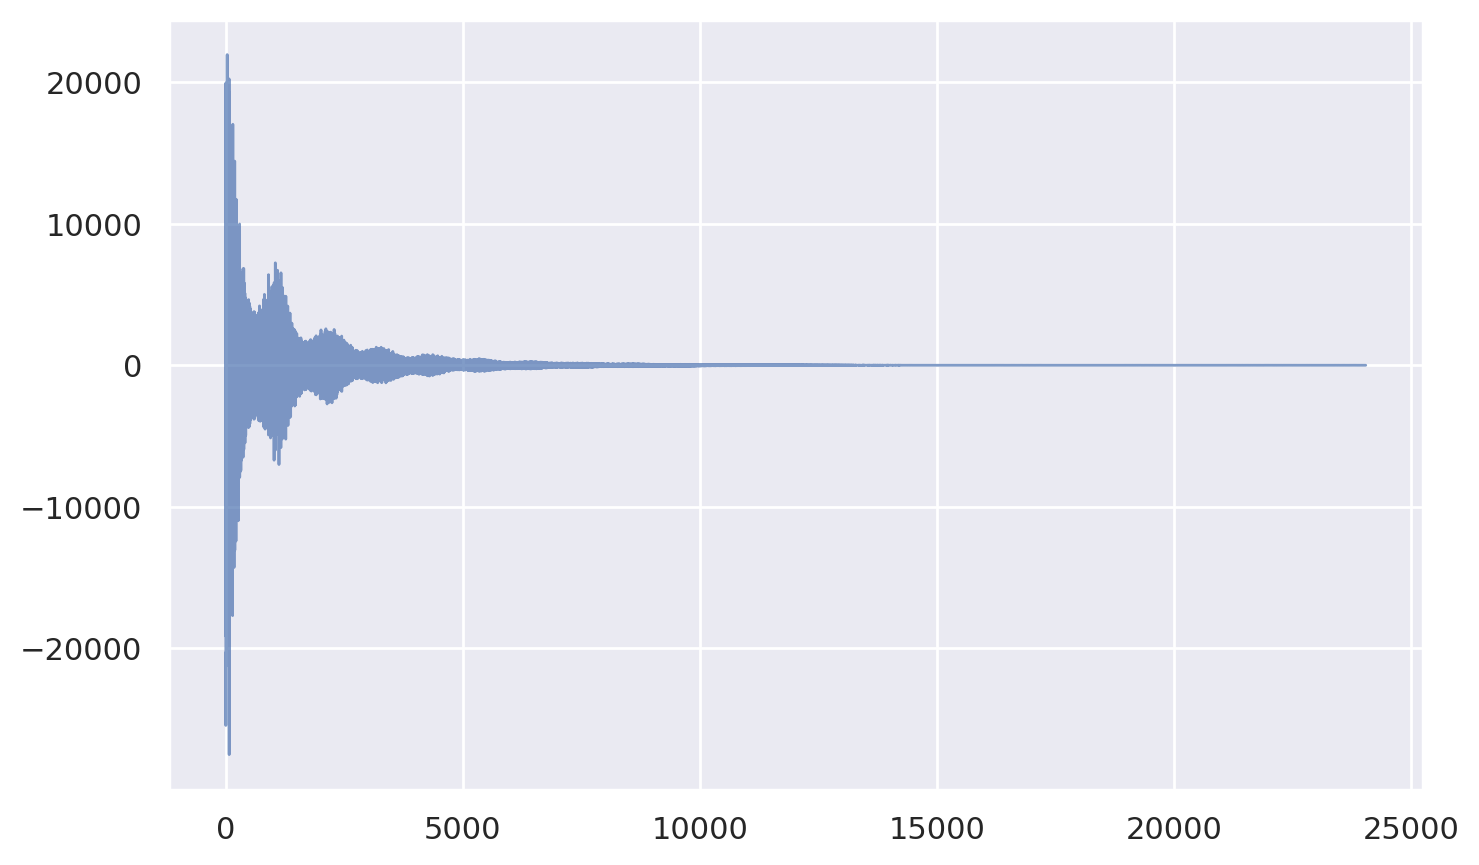

In [8]:
plt.plot(signal.real, label="Re", linewidth=1, alpha=0.7);

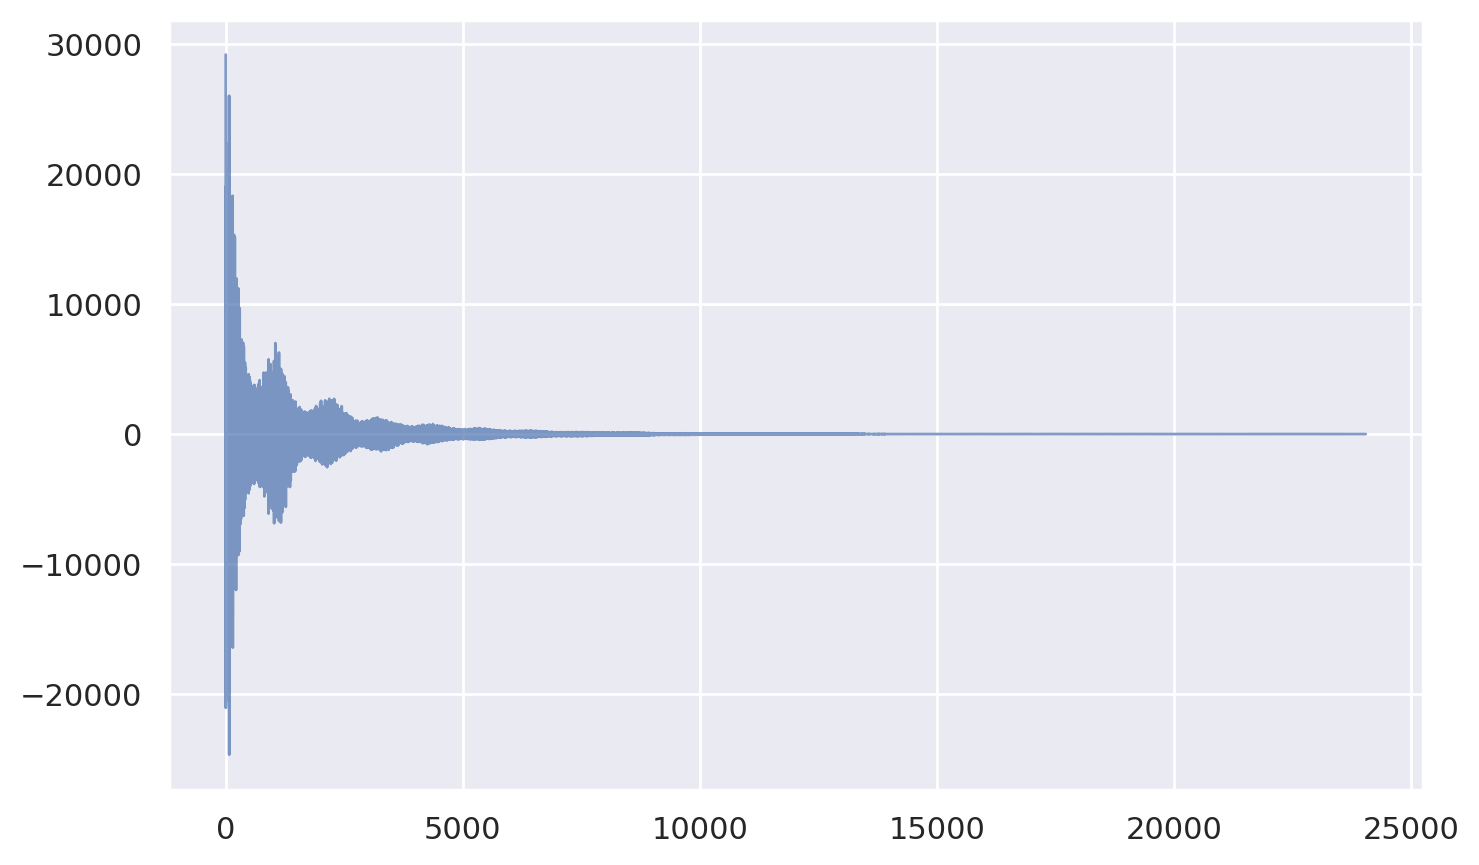

In [9]:
plt.plot(signal.imag, linewidth=1, alpha=0.7);

Мнимые и действительные части очень похожи. Также после 10000 временных единиц график не отличается от нуля

(0.0, 6000.0)

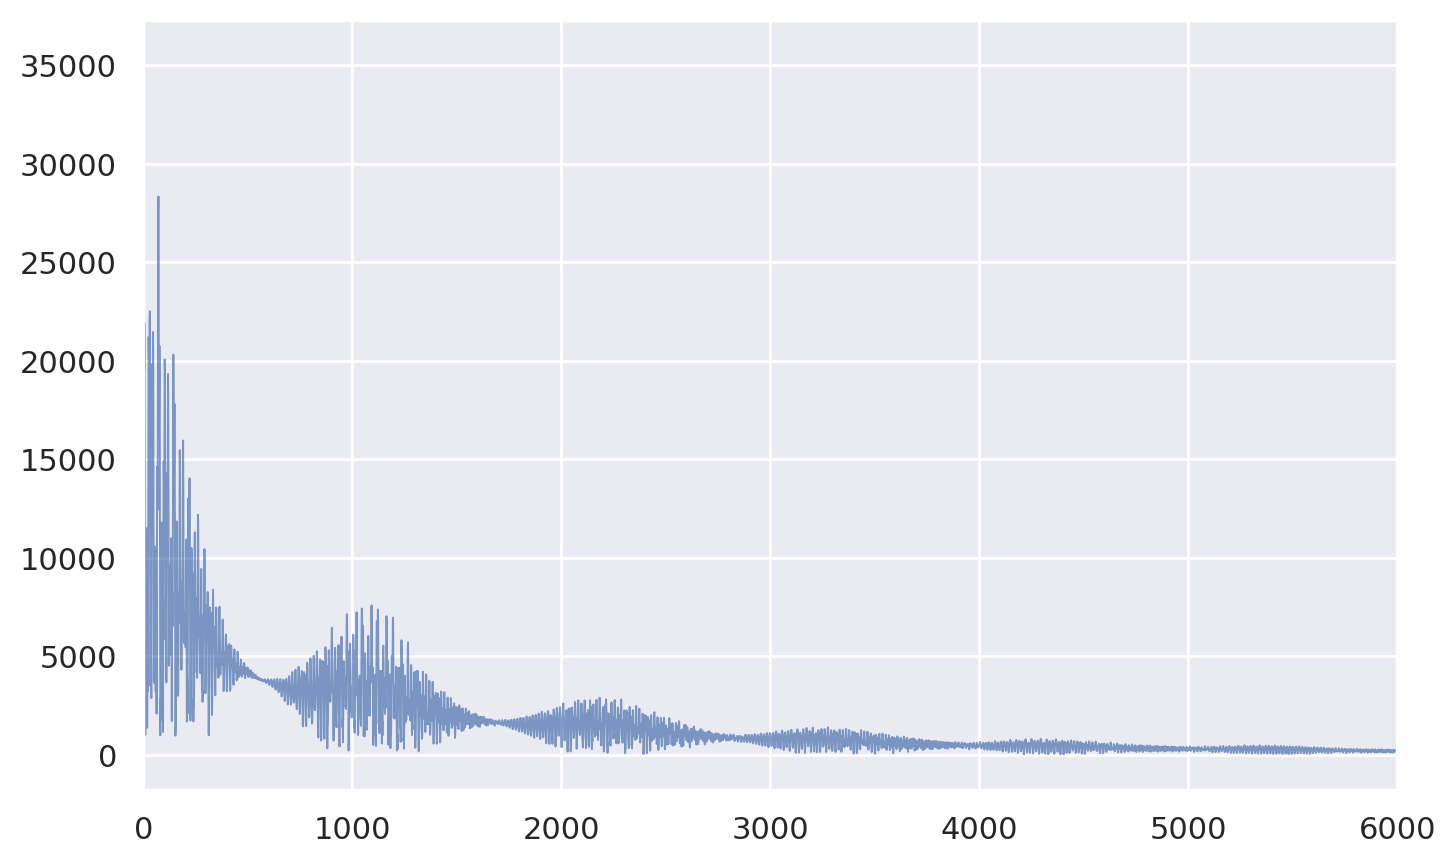

In [10]:
plt.plot(np.abs(signal), linewidth=.7, alpha=0.7)
plt.xlim(0, 6000)

### 1.3 Необработанный спектр

In [11]:
spectrum = nmr.process.proc_base.fft(signal)

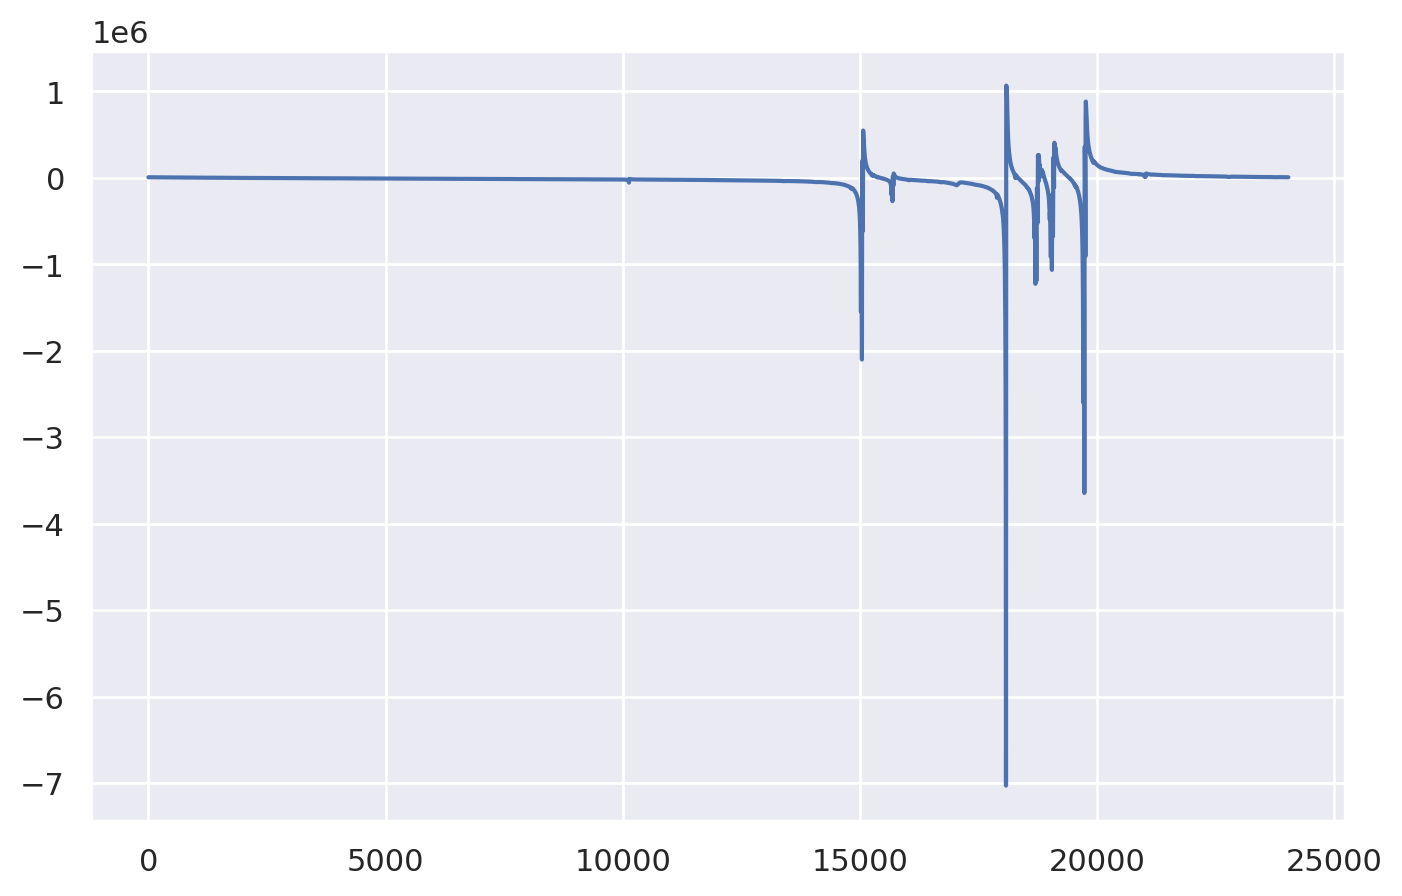

In [12]:
plt.plot(spectrum.real);

## 2. Обработка спектра

### 2.1 Коррекция фазы

#### 2.1.a Встроенная ручная коррекция фазы

Коррекция фазы в ручном режиме встроенной функцией:

In [13]:
nmr.process.proc_autophase.manual_ps(spectrum, notebook=True)

interactive(children=(FloatSlider(value=-0.0015926535897929917, description='phcorr0', max=3.141592653589793, …

Низкая скорость ответа никуда не годится, поэтому приведём гораздо более функциональный вариант.

#### 2.1.b Ручная коррекция фазы

Для создание минимального UI будем пользоваться виджетами Jupyter-а. Возможно они требуют установки отдельной библиотеки, возможно она уже установилась при установки самого Juputer

In [14]:
import ipywidgets as widgets

Ввод коэффициентов для коррекции фазы:

In [15]:
p0_slider = widgets.FloatSlider(
    value=0,
    min=-180,
    max=180,
    step=.5,
)
p0_input = widgets.FloatText(
    value=0,
    min=-180,
    max=180,
    step=.5,
)
p0_label = widgets.Label(value="Zero order phase $\\;p_0$, degrees:")


link = widgets.link((p0_slider, 'value'), (p0_input, 'value'))

p0_block = widgets.VBox([p0_label, p0_slider, p0_input])

In [16]:
p1_slider = widgets.FloatSlider(
    min=-180,
    max=180,
    step=.5,
)
p1_input = widgets.FloatText(
    value=0,
    min=-180,
    max=180,
    step=.5,
)
p1_label = widgets.Label(value="First order phase $\\;p_1$, degrees:")


link = widgets.link((p1_slider, 'value'), (p1_input, 'value'))

p1_block = widgets.VBox([p1_label, p1_slider, p1_input])

In [17]:
phase_correction = widgets.HBox([
    p0_block,
    p1_block
])

Дополнительные параметры

In [18]:
logscale = widgets.Checkbox(
    description="Use logscale for y axis",
    value=False,
    indent=False,
)

subsampling = widgets.Checkbox(
    description="Operate on every 10th point",
    value=False,
    indent=False,
)

fit_y = widgets.Button(
    description="Fit y axis limits",
)

options = widgets.VBox([
    subsampling,
    logscale,
    fit_y,
])

Общий блок с виджетами:

In [19]:
controls = widgets.Tab(
    children=[phase_correction, options],
    titles=["Phase correction", "Options"]
)

Чтобы получить быстрое обновление графиков (и бонусом навигацию), заменим бэкенд `matplotlib` на `ipyml`. Чтобы это можно было сделать, нужно установить библиотеку с таким же названием.

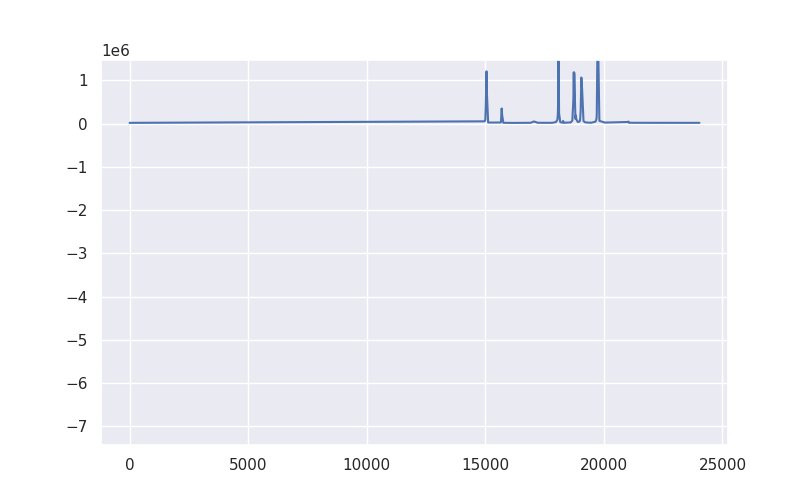

In [32]:
%matplotlib ipympl

matplotlib.style.use('fast') # Could theoretically speed up rendering

if 'figure' in globals():
    # With ipympl you have to manually close previous figures,
    # even from previous runs of the same cell
    plt.close(figure)

figure = plt.figure()
line, = plt.plot(spectrum.real)
xrange = np.arange(spectrum.shape[0])

xrange_subsampled = xrange[::10]
spectrum_subsampled = spectrum[::10]

last_phased_spectrum = np.array([])
last_xrange = np.array([])

def update_ylims(button_clicked):
    x_min, x_max = plt.xlim()
    visible_spectrum = last_phased_spectrum[
        (x_min <= last_xrange) & (last_xrange <= x_max)
    ]
    y_min, y_max = visible_spectrum.min(), visible_spectrum.max()
    yrange = y_max - y_min
    plt.ylim(y_min - 0.1 * yrange, y_max + 0.1 * yrange)

fit_y.on_click(update_ylims)

def redraw_spectrum(p0, p1, subsampling, logscale):
    xrange_ = xrange if not subsampling else xrange_subsampled
    spectrum_ = spectrum if not subsampling else spectrum_subsampled
    
    phased_spectrum = nmr.proc_base.ps(spectrum_, p0, p1).real
    
    if logscale:
        xrange_ = xrange_[phased_spectrum > 0]
        phased_spectrum = np.log(phased_spectrum[phased_spectrum > 0])
    
    line.set_data(xrange_, phased_spectrum)
    
    figure.canvas.draw()
    figure.canvas.flush_events() # Probably not needed

    global last_phased_spectrum, last_xrange
    last_phased_spectrum = phased_spectrum
    last_xrange = xrange_

out = widgets.interactive_output(
    redraw_spectrum,
    {
        'p0': p0_slider,
        'p1': p1_slider,
        'subsampling': subsampling,
        'logscale': logscale,
    }
)

widgets.VBox([controls, out])

Значения только что подобранных вручную коэффициентов:

In [21]:
p0_manual = p0_slider.value
p1_manual = p1_slider.value

p0_manual, p1_manual

(0.0, 0.0)

Интерактивный бекэнд может быть не очень удобен, вернёмся к обычному

#### 2.1.с Автоматическая коррекция фазы

In [22]:
_, (p0_automatic, p1_automatic) = nmr.process.proc_autophase.autops(spectrum, 'acme', p0=0.0, p1=0.0, return_phases=True)

print(f"\nOptimized phases, degrees\n    p0: {p0_automatic}\n    p1: {p1_automatic}")

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 66
         Function evaluations: 133

Optimized phases, degrees
    p0: -143.38389725979368
    p1: 22.502472648582405


In [23]:
autophased_spectrum = nmr.proc_base.ps(spectrum, p0_automatic, p1_automatic).real

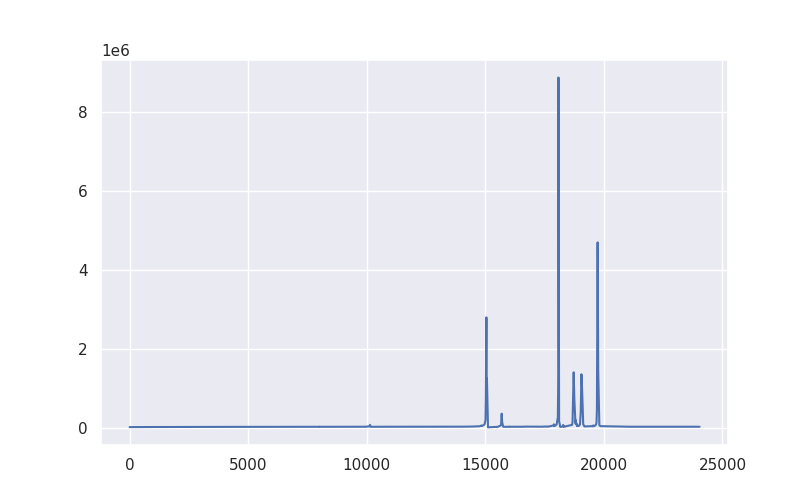

In [24]:
if 'figure_autophased' in locals():
    plt.close(figure_autophased)

figure_autophased = plt.figure()

plt.plot(autophased_spectrum);

#### 2.1.d Результирующая фаза

In [34]:
phase_correction_type = widgets.ToggleButtons(
    options=["Manual", "Automatic"]
    
)

p0, p1 = None, None
phased_spectrum = []

out = widgets.Output()

def update_phase_correction_type(phase_correction_type):
    global p0, p1, phased_spectrum
    
    if phase_correction_type == "Manual":
        p0, p1 = p0_manual, p1_manual
    else:
        p0, p1 = p0_automatic, p1_automatic
        
    phased_spectrum = nmr.proc_base.ps(spectrum, p0, p1).real
    print(f"Using '{phase_correction_type}' phase correction")
    
out = widgets.interactive_output(
    update_phase_correction_type,
    dict(phase_correction_type=phase_correction_type)
)

widgets.VBox([phase_correction_type, out])

### 2.2 Коррекция базового уровня

Коррекция базового уровня выполняется с помощью функций подмодуля `nmrglue.proc_bl`. К сожалению их документация слишком скудна чтобы понять, как их правильно использовать, поэтому воспользуемся одной из тех, что не требуют обязательных параметров...

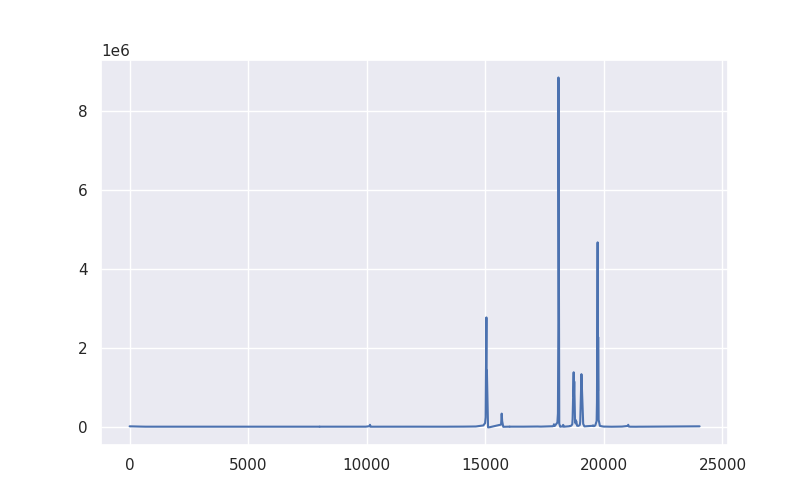

In [37]:
based_spectrum = nmr.proc_bl.baseline_corrector(phased_spectrum)

if 'figure_baseline' in globals():
    plt.close(figure_baseline)

figure_baseline = plt.figure()

plt.plot(based_spectrum)

Базовая линия действительно улучшилась

### 2.3 Zero correction

???

## 3 Анализ спектров

### 3.1 Интегрирование пиков

In [38]:
peak_x_ranges = [
    (15000, 15100),
    (15600, 15800),
    (17900, 18300),
    (18600, 18900),
    (18900, 19200),
    (19600, 19900),
]

# Peaks can also be determined automatically:
nmr.analysis.peakpick.pick(based_spectrum, pthres=50000, table=True, algorithm="connected")

rec.array([(15046., 1, 41.36474544, 6.05461409e+07),
           (15690., 2, 40.45514422, 5.56848091e+06),
           (17893., 3,  2.        , 1.69474630e+05),
           (18084., 4,  5.10588642, 8.99526475e+07),
           (18726., 5, 51.98917963, 6.81613294e+07),
           (18854., 6,  4.        , 3.00133294e+05),
           (19053., 7, 70.69649119, 6.70701487e+07),
           (19736., 8, 26.43947244, 1.02676743e+08)],
          dtype=[('X_AXIS', '<f8'), ('cID', '<i8'), ('X_LW', '<f8'), ('VOL', '<f8')])

Автоматическое определение пиков занижает ширину некоторых пиков и даёт ложные срабатывания, поэтому будем использовать размеченные вручную.

Интегрирование пиков будем производить вручную. Хотя `nmrglue` и имеет подмодуль `nmrglue.analysis.integration`, он содержит всего две функции (для одномерного и многомерного интегрирования). По неизвестным причинам он в качестве обязательного параметра принимает `filebaseio.unit_conversion`- объект, предназначенный для работы с размерностями. При создании напрямую он требует 5 обязательных параметров, которые не хочется искать. Адекватный способ создания в документации приведён, но зависит от формата данных (так как подтягивает эти параметры из метаданных, которые у каждого формата свои). У вариана этой функции нет. Можно сконвертировать в pipe, но эти значения будут заполнены случайно.

Вместо всего это безобразия вызванного незрелостью библиотеки достаточно просто сделать `np.sum()`. 

In [29]:
peak_integrals = [
    based_spectrum[x_min:x_max].sum()
    for x_min, x_max in peak_x_ranges
]

peak_integrals

[-31682604.08261356,
 -4874410.991525508,
 -75866475.48008841,
 -56032811.89489354,
 -29066455.61593309,
 -38848725.16666518]

In [30]:
relative_integrals = peak_integrals / peak_integrals[0]

print(*[f"{value:.2f}" for value in relative_integrals], sep="\n")

1.00
0.15
2.39
1.77
0.92
1.23


In [31]:
mult =  5
print(*[f"{value:.2f}" for value in relative_integrals * mult], sep="  ")

5.00  0.77  11.97  8.84  4.59  6.13


### 3.2 Химические сдвиги

Как их рассчитать без нуля.... И в чём они вообще... И чё с шкалой частоты делать???

### 3.3 Расщепления

Ну тут все смогут пик приблизить и посмотреть на него...
Правда в нескольких местах действительно неочевидно из-за фона

## Результы/Выводы

ту ту та ту ту то